In [1]:
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
import numpy as np
import matplotlib.pyplot as plt
import random
import math 
from math import ceil
import os
import pickle
import gc

from OneNucleotideIndexer import OneNucleotideIndexer

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import Sequence
from keras.models import Model, load_model
from tensorflow.keras.layers import Layer
from keras.layers import Masking,Reshape, Lambda, Concatenate,Input, Dense, BatchNormalization, Conv1D, Flatten, Activation, Embedding, GlobalMaxPooling1D, SeparableConv1D, Conv1DTranspose
from Metrics import specificity


2025-06-03 12:53:10.875075: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-03 12:53:10.916826: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-03 12:53:11.536170: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
Data_for_model_path = '/media/zakaria/spin/SayantanProteinFamily/Uniref_Uniprot/Data_for_model' #'/mnt/e/GenerativeAI_generated_sequences/Data'
uniprotKB_file      = f'{Data_for_model_path}/uniprot_sprot.fasta'
bacterium_fastafile = f'{Data_for_model_path}/positive.fasta'

final_train_fastafile     = f'{Data_for_model_path}/Data_from_Sir/train_uniprot_confirmed.fasta'
final_val_fastafile     = f'{Data_for_model_path}/Data_from_Sir/valid_uniprot_confirmed.fasta'

model_input_data = f'{Data_for_model_path}/uniref50_model_data/model_inputs'
saved_model_path   = f'{Data_for_model_path}/Models'
encoder_model_path = f'{saved_model_path}/network_classifier_features_20250217_091829.h5'
min_len = 50
max_len = 1024

# stats

In [3]:
def check_max_len(fastafile):
    max_len = 0
    with open(fastafile) as file:
        for record in SeqIO.parse(file,"fasta"):
            # print(record)
            # break
            if len(record.seq) > max_len:
                max_len = len(record.seq)
                protein_id = record.id
    print(f"max_len in this fasta_file is {max_len} for protein id {protein_id}")
    # return protein_id,max_len

In [4]:
def collect_seq_lengths(fastafile):
    lengths=[]
    with open(fastafile) as file:
        for record in SeqIO.parse(fastafile,"fasta"):
            lengths.append(len(record.seq))
    print(f"total number of sequences on file: {len(lengths)}")
    return lengths

In [5]:
def make_hist_std_mean(listoflengths,file_name=None):
    if file_name is not None:
        std_deviation = np.std(listoflengths)
        print(f"std of {file_name} is : {std_deviation}")
        average_length = np.mean(listoflengths)
        print(f"average_length of {file_name} is : {average_length}")
        # Plot histogram
        plt.figure(figsize=(8, 5))
        plt.hist(listoflengths, bins=30, color='skyblue', edgecolor='black')
        plt.axvline(average_length, color='red', linestyle='dashed', linewidth=1.5, label=f'Avg: {average_length:.2f}')
        plt.axvline(average_length + std_deviation, color='green', linestyle='dotted', linewidth=1.5, label=f'+1 SD: {average_length + std_deviation:.2f}')
        plt.axvline(average_length - std_deviation, color='green', linestyle='dotted', linewidth=1.5, label=f'-1 SD: {average_length - std_deviation:.2f}')
        plt.title(f"Histogram of Sequence Lengths of {file_name}")
        plt.xlabel("Sequence Length")
        plt.ylabel("Frequency")
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        print("no file_name provided")

<b> Data from Sir stats <b>

max_len in this fasta_file is 1024 for protein id NC_009952.1_32254
total number of sequences on file: 757338
std of train_uniprot_confirmed File is : 198.51273076562046
average_length of train_uniprot_confirmed File is : 328.801418917313


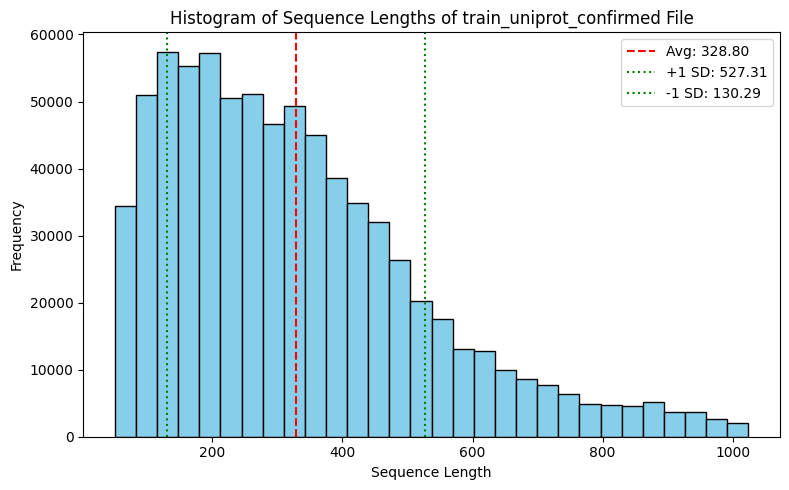

max_len in this fasta_file is 1024 for protein id AP024675.1_6006
total number of sequences on file: 216382
std of valid_uniprot_confirmed File is : 198.31337191901713
average_length of valid_uniprot_confirmed File is : 328.33476906581876


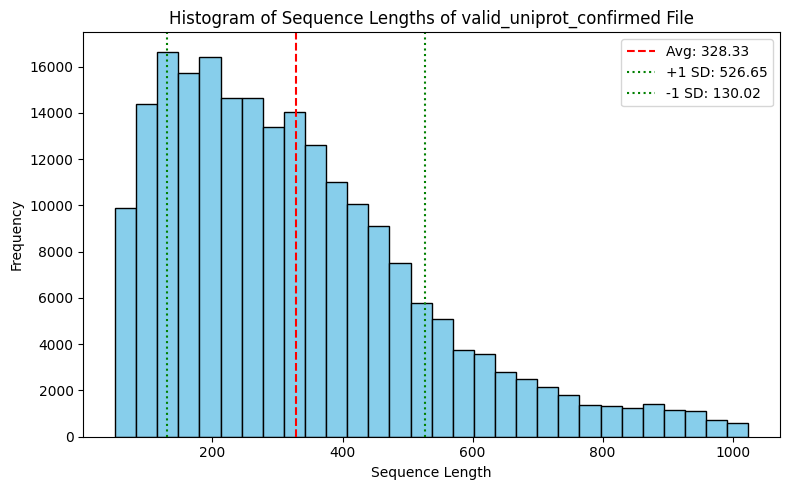

In [7]:
check_max_len(f'{Data_for_model_path}/Data_from_Sir/train_uniprot_confirmed.fasta')
list_seq_lengths = collect_seq_lengths(f'{Data_for_model_path}/Data_from_Sir/train_uniprot_confirmed.fasta')
make_hist_std_mean(list_seq_lengths, "train_uniprot_confirmed File")

check_max_len(f'{Data_for_model_path}/Data_from_Sir/valid_uniprot_confirmed.fasta')
list_seq_lengths = collect_seq_lengths(f'{Data_for_model_path}/Data_from_Sir/valid_uniprot_confirmed.fasta')
make_hist_std_mean(list_seq_lengths, "valid_uniprot_confirmed File")

<b> Make binned dataset <b>

In [8]:
def custom_sequences(uniprotKB_file, seq_frags_file, max_count=10, max_len=max_len, min_len=min_len):#,seq_frags_file):    
    with open(uniprotKB_file) as file:
        bins = np.linspace(min_len, max_len, num=100, dtype=int)
        seqlen_dict    = {}
        for bin_val in bins:
            seqlen_dict[bin_val] = []

        for record in SeqIO.parse(file, "fasta"):
            uniprot_id = record.id
            name       = record.id
            seq_len = len(record.seq)

            if seq_len < min_len or seq_len > max_len:
                continue

            closest_bin = bins[0] # initialize the first bin=50
            min_diff = abs(bins[0] - seq_len) # track smallest difference
            for bin_val in bins:
                diff = abs(bin_val - seq_len)
                if diff < min_diff:
                    min_diff = diff
                    closest_bin = bin_val
            if len(seqlen_dict[closest_bin]) < max_count:
                seq_frag = record.seq
                frag_record = SeqRecord(seq_frag, f"{uniprot_id}_{seq_len}", name = name, description="")
                seqlen_dict[closest_bin].append(frag_record)

        all_frags = []
        for bin_key,seq_list in seqlen_dict.items():
            all_frags.extend(seq_list[:max_count])

        if all_frags:
            with open(seq_frags_file, "w") as output:
                SeqIO.write(all_frags, output, "fasta")
        else:
            print("no sequences found")  

In [7]:
orig_file = uniprotKB_file
output_fasta = f'{Data_for_model_path}/binned_uniprotkb.fasta'
custom_sequences(orig_file,output_fasta, max_count=5000)  #104299

max_len in this fasta_file is 1024 for protein id sp|Q7TQI7|ABTB2_MOUSE_1024
total number of sequences on file: 320432
std of binned_uniprotkb File is : 222.0071462820371
average_length of binned_uniprotkb File is : 389.8032811953862


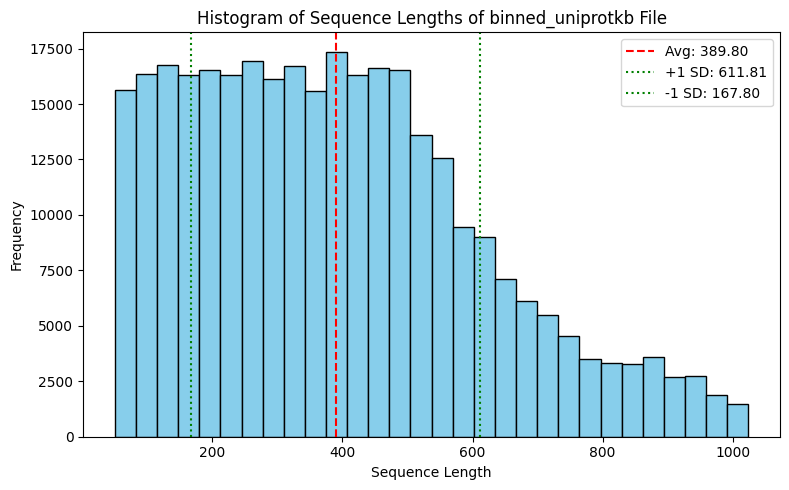

In [8]:
check_max_len(f'{Data_for_model_path}/binned_uniprotkb.fasta')
list_seq_lengths = collect_seq_lengths(f'{Data_for_model_path}/binned_uniprotkb.fasta')
make_hist_std_mean(list_seq_lengths, "binned_uniprotkb File")

In [10]:
orig_file = bacterium_fastafile
output_fasta = f'{Data_for_model_path}/binned_bacterium.fasta'
custom_sequences(orig_file,output_fasta, max_count=5000)  #104299

max_len in this fasta_file is 1024 for protein id NZ_CP029347.1_26374_1024
total number of sequences on file: 468183
std of binned_bacterium File is : 268.4847016829706
average_length of binned_bacterium File is : 507.9095311021545


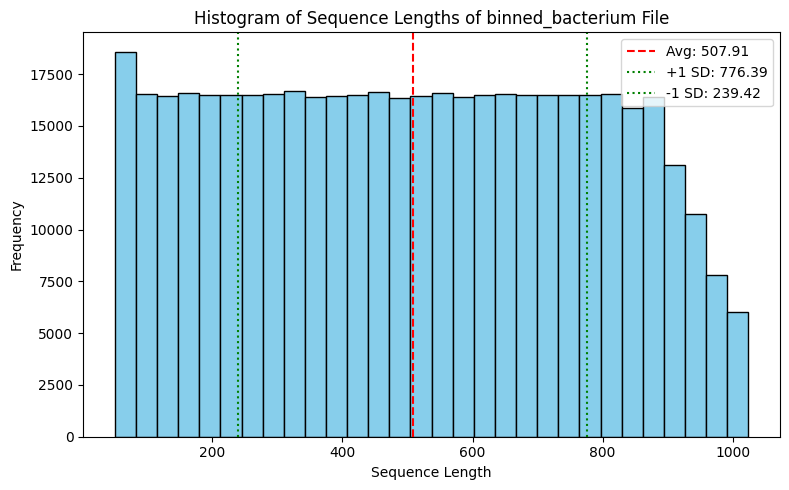

In [11]:
check_max_len(f'{Data_for_model_path}/binned_bacterium.fasta')
list_seq_lengths = collect_seq_lengths(f'{Data_for_model_path}/binned_bacterium.fasta')
make_hist_std_mean(list_seq_lengths, "binned_bacterium File")

<b> total merged file has 1339569 sequences <b> <br>
##with 1000 194515 seqs 136161/38903/19451

In [12]:
merged_uni_bact_fastafile = f'{Data_for_model_path}/merged_uni_bact_fastafile.fasta'

<b>Custom Validation fasta file of 1000 sequences distributed in 100 bins<b>

In [9]:
'''binning the validation data from the data from Sir '''
orig_file = final_val_fastafile
output_fasta = f'{Data_for_model_path}/Data_from_Sir/binned_final_val_fastafile.fasta'
custom_sequences(orig_file,output_fasta)

max_len in this fasta_file is 1024 for protein id AP024675.1_6006_1024
total number of sequences on file: 1000
std of binned_final_val_fastafile File is : 283.89025952998105
average_length of binned_final_val_fastafile File is : 536.888


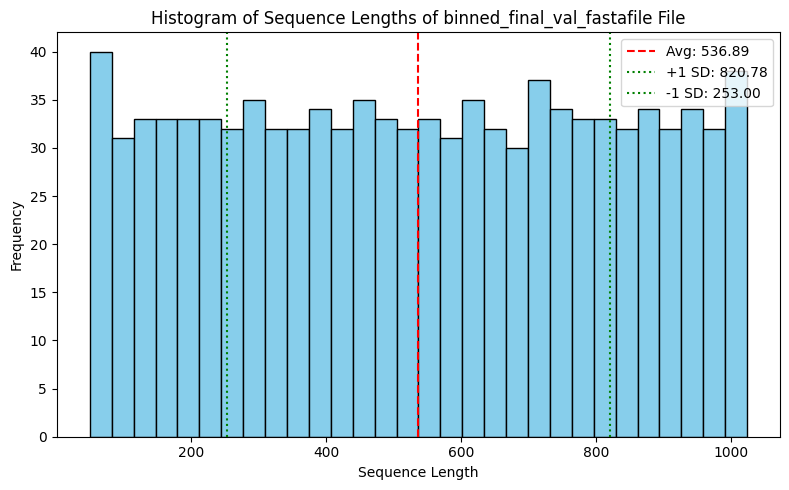

In [10]:
''' Checking binned val data from the data from Sir  '''
check_max_len(f'{Data_for_model_path}/Data_from_Sir/binned_final_val_fastafile.fasta')
list_seq_lengths = collect_seq_lengths(f'{Data_for_model_path}/Data_from_Sir/binned_final_val_fastafile.fasta')
make_hist_std_mean(list_seq_lengths, "binned_final_val_fastafile File")

In [20]:
orig_file = f'{Data_for_model_path}/merged_uni_bact_val_seqs.fasta'
output_fasta = f'{Data_for_model_path}/binned_1000_uni_bact_val_seqs.fasta'
custom_sequences(orig_file,output_fasta)  #104299

max_len in this fasta_file is 1024 for protein id NZ_CP039964.1_18019_1024_1024
total number of sequences on file: 1000
std of binned_1000_uni_bact_val_seqs File is : 283.92304661650843
average_length of binned_1000_uni_bact_val_seqs File is : 536.96


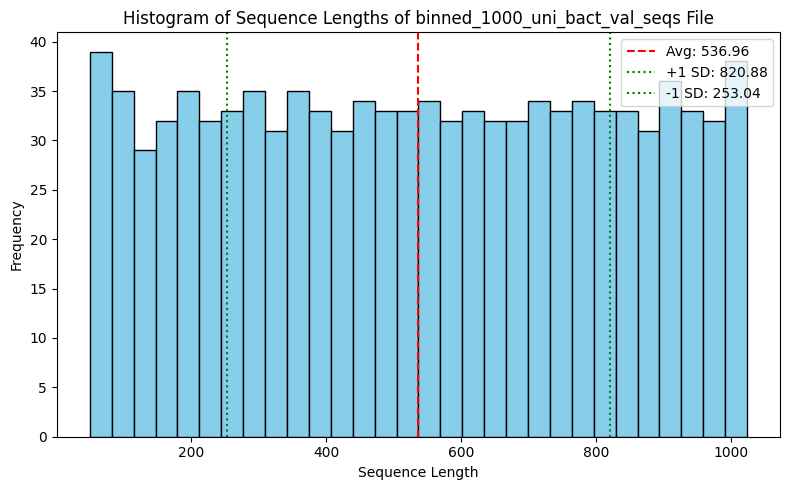

In [21]:
check_max_len(f'{Data_for_model_path}/binned_1000_uni_bact_val_seqs.fasta')
list_seq_lengths = collect_seq_lengths(f'{Data_for_model_path}/binned_1000_uni_bact_val_seqs.fasta')
make_hist_std_mean(list_seq_lengths, "binned_1000_uni_bact_val_seqs File")

# Divide the merged file into train/val/test

In [13]:
def seqrecord_distribution(seq_frags_file):
    '''
    Uniprot fasta file grouped into seqs that match 50 <= seq_len <= 1024
    no further dividing seqs > 1024 length
    '''
    train_ratio=0.7
    val_ratio  =0.2
    test_ratio =0.1
    seq_list   = []
    with open(seq_frags_file) as file: #seq_frags_file
        for record in SeqIO.parse(file, "fasta"):
            seq_list.append(record)
            
    random.shuffle(seq_list)   
    seq_groups = len(seq_list) // 10
    seq_remain = len(seq_list) % 10
    ''' Calculate number of sequences for each dataset '''
    # train_count = ceil(len(seq_list) * train_ratio)
    # val_count   = ceil(len(seq_list) * val_ratio)
    # test_count  = len(seq_list) - train_count - val_count
    # print("train_count: ", train_count)
    # print("val_count: ", val_count)
    # print("test_count: ", test_count)
    
    train_seqs, val_seqs, test_seqs = [], [], []
    first_groupofseqs_printed = False
    
    for i in range(0, len(seq_list) - seq_remain, 10):
        seq_records = seq_list[i: i + 10]
        train_seqs.extend(seq_records[:7])
        val_seqs.extend(seq_records[7:9])
        test_seqs.extend([seq_records[9]])
    # print(len(train_seqs),len(val_seqs),len(test_seqs))
        # if first_groupofseqs_printed==False:
        #     print(f"seq_records {i//10 + 1}: {seq_records}")
        #     print(f"Assigned to training: {seq_records[:7]}")
        #     print(f"Assigned to validation: {seq_records[7:9]}")
        #     print(f"Assigned to testing: {seq_records[9]}")
        #     first_cluster_printed = True
    if seq_remain > 0:
        remaining_records = seq_list[-seq_remain:]
        remaining_train_count = ceil(len(remaining_records) * train_ratio)  
        remaining_val_count = ceil(len(remaining_records) * val_ratio)    
        # remaining_test_count = remaining_records - remaining_train_count - remaining_val_count 
    
        train_seqs.extend(remaining_records[:remaining_train_count])
        val_seqs.extend(remaining_records[remaining_train_count:remaining_train_count+remaining_val_count])
        test_seqs.extend(remaining_records[remaining_train_count+remaining_val_count:])

    return (train_seqs, val_seqs, test_seqs)

In [14]:
train_files, val_files, test_files = seqrecord_distribution(merged_uni_bact_fastafile)

In [15]:
len(train_files), len(val_files), len(test_files)

(552031, 157723, 78861)

### Save train/val/test into corresponding fasta files

In [16]:
# Function to save sequences to FASTA files
def save_fasta(seq_list, filename):
    filepath = os.path.join(Data_for_model_path, filename)
    with open(filepath, "w") as file:
        SeqIO.write(seq_list, file, "fasta")

In [17]:
save_fasta(train_files, "merged_uni_bact_train_seqs.fasta")
save_fasta(val_files, "merged_uni_bact_val_seqs.fasta")
save_fasta(test_files, "merged_uni_bact_test_seqs.fasta")

max_len in this fasta_file is 1024 for protein id sp|Q9NPP4|NLRC4_HUMAN_1024
total number of sequences on file: 552031
std of merged_uni_bact_train_seqs is : 257.32790676941914
average_length of merged_uni_bact_train_seqs is : 459.78339803380607


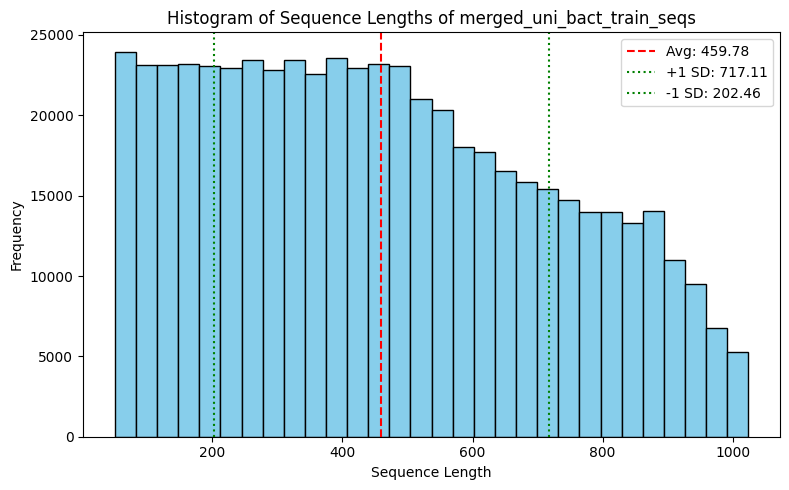

max_len in this fasta_file is 1024 for protein id NZ_CP039964.1_18019_1024
total number of sequences on file: 157723
std of merged_uni_bact_val_seqs is : 256.8524155596161
average_length of merged_uni_bact_val_seqs is : 460.1416217038732


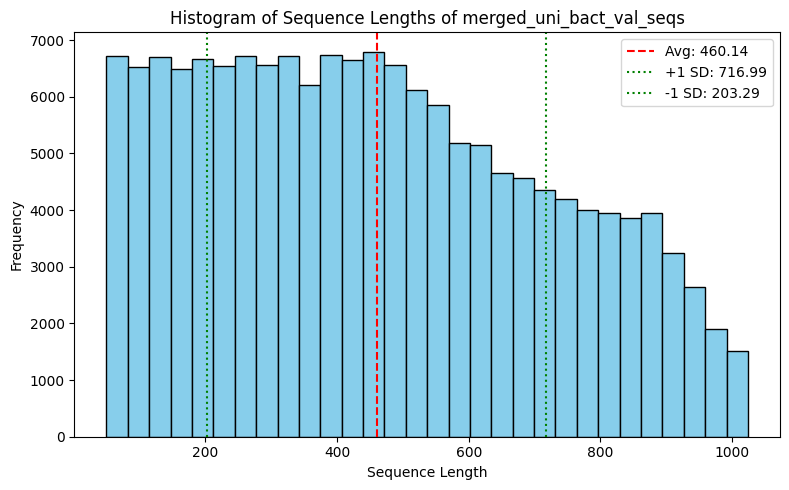

max_len in this fasta_file is 1024 for protein id NZ_LN849456.1_15557_1024
total number of sequences on file: 78861
std of merged_uni_bact_test_seqs is : 257.6622023325393
average_length of merged_uni_bact_test_seqs is : 460.4360457006632


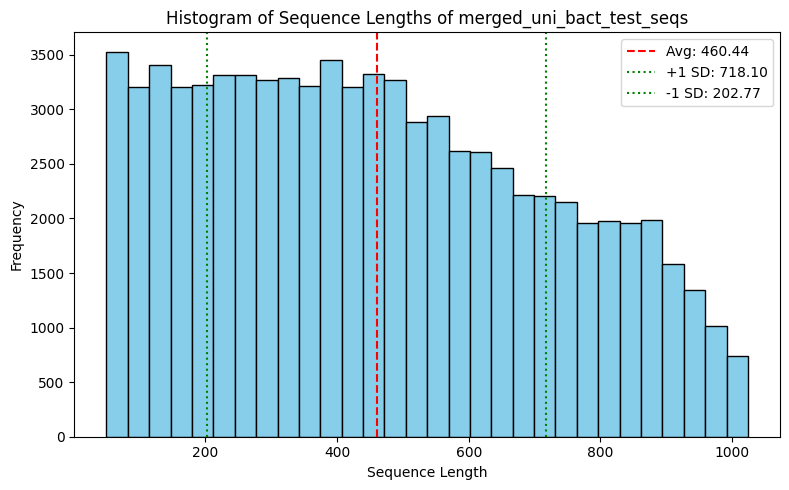

In [18]:
check_max_len(f'{Data_for_model_path}/merged_uni_bact_train_seqs.fasta')
list_uniprot_lengths = collect_seq_lengths(f'{Data_for_model_path}/merged_uni_bact_train_seqs.fasta')
make_hist_std_mean(list_uniprot_lengths, "merged_uni_bact_train_seqs")

check_max_len(f'{Data_for_model_path}/merged_uni_bact_val_seqs.fasta')
list_uniprot_lengths = collect_seq_lengths(f'{Data_for_model_path}/merged_uni_bact_val_seqs.fasta')
make_hist_std_mean(list_uniprot_lengths, "merged_uni_bact_val_seqs")

check_max_len(f'{Data_for_model_path}/merged_uni_bact_test_seqs.fasta')
list_uniprot_lengths = collect_seq_lengths(f'{Data_for_model_path}/merged_uni_bact_test_seqs.fasta')
make_hist_std_mean(list_uniprot_lengths, "merged_uni_bact_test_seqs")

<b> fasta files to use <b>

In [3]:
train_fastafile = f'{Data_for_model_path}/merged_uni_bact_train_seqs.fasta'
val_fastafile   = f'{Data_for_model_path}/merged_uni_bact_val_seqs.fasta'
test_fastafile  = f'{Data_for_model_path}/merged_uni_bact_test_seqs.fasta'

In [4]:
# val_binnedseqs  = f'{Data_for_model_path}/binned_1000_uni_bact_val_seqs.fasta'

In [3]:
val_binnedseqs  = f'{Data_for_model_path}/Data_from_Sir/val_binned/binned_final_val_fastafile.fasta'

# Directly Load New Indexer

In [9]:
new_indexer_file        = f"{model_input_data}/A_U_len{max_len}_20250217_091829.pkl"

In [10]:
new_indexer_file

'/media/zakaria/spin/SayantanProteinFamily/Uniref_Uniprot/Data_for_model/uniref50_model_data/model_inputs/A_U_len1024_20250217_091829.pkl'

In [11]:
with open(new_indexer_file, "rb") as f:
    new_index_table = pickle.load(f)

In [12]:
for kmer,index in new_index_table.index_table.items():
    print(kmer, index)

A 2
R 3
H 4
I 5
E 6
P 7
G 8
L 9
V 10
D 11
Y 12
W 13
S 14
Q 15
M 16
T 17
F 18
N 19
K 20
C 21
U 22


# F-matrix

In [4]:
# seq_list = list(SeqIO.parse(final_train_fastafile, "fasta"))
# seq_list = list(SeqIO.parse(final_val_fastafile, "fasta"))

# seq_list = list(SeqIO.parse(train_fastafile, "fasta"))
# seq_list = list(SeqIO.parse(val_fastafile, "fasta"))
# seq_list = list(SeqIO.parse(test_fastafile, "fasta"))
seq_list = list(SeqIO.parse(val_binnedseqs, "fasta"))

In [5]:
len(seq_list)

1000

In [6]:
max_len = float("-inf")
for record in seq_list:
    if len(record.seq) > max_len:
        max_len = len(record.seq)
        max_id = record.id

In [7]:
max_len,max_id

(1024, 'AP024675.1_6006_1024')

In [13]:
new_index_table

In [14]:
indexer = OneNucleotideIndexer(max_len = max_len, another_indexer = new_index_table)

In [15]:
f_matrix = indexer.encode_list_parallel(seq_list)

In [16]:
f_matrix.shape

(1000, 1024)

In [15]:
# np.save(f'{model_input_data}/final_train_fmatrix_{max_len}.npy', f_matrix)

# np.save(f'{model_input_data}/merged_uni_bact_train_fmatrix_{max_len}.npy', f_matrix)
# np.save(f'{model_input_data}/merged_uni_bact_val_fmatrix_{max_len}.npy', f_matrix)
# np.save(f'{model_input_data}/merged_uni_bact_test_fmatrix_{max_len}.npy', f_matrix)
# np.save(f'{model_input_data}/binned_1000_uni_bact_val_seqs_fmat.npy', f_matrix)

In [38]:
# del f_matrix
# gc.collect()

# Embedding layer from pre-trained encoder

In [17]:
class CustomConvLayer(Layer):
    def __init__(self, filter_num, filter_size, **kwargs):
        super(CustomConvLayer, self).__init__(**kwargs)
        self.filter_num = filter_num
        self.filter_size = filter_size
        self.conv1 = Conv1D(filters=filter_num, kernel_size=filter_size, use_bias=True,  activation='relu', name='conv1')
        self.conv2 = Conv1D(filters=filter_num, kernel_size=(2*filter_size)+1, use_bias=False, strides=2, name='conv2')# 
        self.bn = BatchNormalization(name='bn')
        self.activation = Activation(activation='relu', name='relu')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.bn(x)
        x = self.activation(x)
        return x

    def get_config(self):
        config = super(CustomConvLayer, self).get_config()
        config.update({
            'filter_num': self.filter_num,
            'filter_size': self.filter_size
        })
        return config
    
    def set_weights(self, weight_list):
        self.conv1.set_weights(weight_list[:2])
        self.conv2.set_weights(weight_list[2:3])
        self.bn.set_weights(weight_list[3:])

    def freeze_layers(self):
        self.conv1.trainable = False
        self.conv2.trainable = False
        self.bn.trainable    = False

    def unfreeze_layers(self):
        self.conv1.trainable = True
        self.conv2.trainable = True
        self.bn.trainable    = True

In [18]:
encoder_model = load_model(encoder_model_path, custom_objects={'CustomConvLayer': CustomConvLayer, 'specificity': specificity})
embedding_layer = encoder_model.get_layer(name='embedding')

2025-06-03 12:56:10.332297: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 666 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:b3:00.0, compute capability: 8.6


In [19]:
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_tensor (InputLayer)   [(None, 1024)]            0         
                                                                 
 embedding (Embedding)       (None, 1024, 3)           81        
                                                                 
 custom_conv_layer (CustomC  (None, 508, 32)           7616      
 onvLayer)                                                       
                                                                 
 custom_conv_layer_1 (Custo  (None, 250, 64)           35136     
 mConvLayer)                                                     
                                                                 
 custom_conv_layer_2 (Custo  (None, 121, 128)          139904    
 mConvLayer)                                                     
                                                           

In [20]:
print("Input shape of the model:", encoder_model.input_shape)

Input shape of the model: (None, 1024)


### Freeze all encoder layers

In [21]:
for layer in encoder_model.layers:
    if isinstance(layer, CustomConvLayer):
        layer.freeze_layers()
    else:
        layer.trainable = False

### Get the trained embedding layer

In [22]:
embedding_matrix = embedding_layer.get_weights()[0]
# Display the vocabulary and their corresponding embedding values
vocab_size, embedding_dim = embedding_matrix.shape
print("Vocabulary Size:", vocab_size)
print("Embedding Dimension:", embedding_dim)
print("\nVocabulary and Embedding Values:\n")

for token_id in range(vocab_size):
    print(f"Token ID {token_id}: {embedding_matrix[token_id]}")

Vocabulary Size: 27
Embedding Dimension: 3

Vocabulary and Embedding Values:

Token ID 0: [-0.02140465  0.02830246 -0.05574557]
Token ID 1: [ 0.01456194 -0.04204811  0.03270236]
Token ID 2: [-0.06271231 -0.11801422 -0.05803983]
Token ID 3: [ 0.07430171  0.29197326 -0.23212597]
Token ID 4: [ 0.01646761  0.70462066 -0.6810645 ]
Token ID 5: [-0.28561434  0.14610802 -0.00950604]
Token ID 6: [-0.16307573 -0.5325746   0.07229828]
Token ID 7: [0.5686764  0.1469355  0.09788614]
Token ID 8: [-0.38822517  0.09971034 -0.5219342 ]
Token ID 9: [-0.27956656  0.05687758  0.07124779]
Token ID 10: [-0.34459665 -0.01498139 -0.14375386]
Token ID 11: [-0.00147066 -0.21718769 -0.10160962]
Token ID 12: [ 0.19393146 -0.26964355  0.35422647]
Token ID 13: [ 0.45520952 -0.15856832  0.37196437]
Token ID 14: [0.35017297 0.27239195 0.01043969]
Token ID 15: [-0.08567002  0.08376089 -0.37251484]
Token ID 16: [0.00457283 0.6379865  1.3526993 ]
Token ID 17: [-0.00031182 -0.06125099  0.29761612]
Token ID 18: [ 0.053938

A 2
R 3
H 4
I 5
E 6
P 7
G 8
L 9
V 10
D 11
Y 12
W 13
S 14
Q 15
M 16
T 17
F 18
N 19
K 20
C 21
X 22
U 23
Z 24
B 25
O 26

# F_matrix_embedded

In [13]:
# Load the f_matrix on CPU
# with tf.device('/CPU:0'):
#     f_matrix = np.load(f'{model_input_data}/final_train_fmatrix_{max_len}.npy')

#     f_matrix = np.load(f'{model_input_data}/merged_uni_bact_train_fmatrix_{max_len}.npy')
    # f_matrix = np.load(f'{model_input_data}/merged_uni_bact_val_fmatrix_{max_len}.npy')
    # f_matrix = np.load(f'{model_input_data}/merged_uni_bact_test_fmatrix_{max_len}.npy')
    # f_matrix = np.load(f'{model_input_data}/binned_1000_uni_bact_val_seqs_fmat.npy')

In [23]:
f_matrix.shape

(1000, 1024)

In [24]:
def encode_sequences(input_array):
    """
    This function was generated by ChatGPT
    This function takes a numpy array of integer-encoded sequences, runs each sequence
    through the embedding layer, and returns the embedded representations.

    Parameters:
    input_array (numpy.ndarray): A 2D numpy array where each row is a sequence of integer tokens.

    Returns:
    numpy.ndarray: A 3D numpy array of embedded values.
    """    
    # embedded_output = embedding_layer(input_array)
    embedded_output = embedding_layer(input_array).numpy()  # (batch, seq_len, d)

    # zero out every embedding-vector where input_array == 0
    embedded_output[input_array == 0] = 0.0

    # Convert the embedded output to numpy array and return it
    # return embedded_output.numpy()
    return embedded_output

In [25]:
with tf.device('/CPU:0'):
    f_matrix_embedded = encode_sequences(f_matrix)

In [26]:
f_matrix_embedded.shape

(1000, 1024, 3)

In [27]:
# np.save(f'{model_input_data}/final_val_fmatrixEmbed_{max_len}.npy', f_matrix_embedded)
np.save(f'{model_input_data}/binned_final_val_fmatrixEmbed_{max_len}.npy', f_matrix_embedded)

# np.save(f'{model_input_data}/merged_uni_bact_train_fmatrixEmbed_{max_len}.npy', f_matrix_embedded)
# np.save(f'{model_input_data}/merged_uni_bact_val_fmatrixEmbed_{max_len}.npy', f_matrix_embedded)
# np.save(f'{model_input_data}/merged_uni_bact_test_fmatrixEmbed_{max_len}.npy', f_matrix_embedded)
# np.save(f'{model_input_data}/binned_1000_uni_bact_val_seqs_fmatEmbed.npy', f_matrix_embedded)

In [28]:
del f_matrix_embedded
gc.collect()

300